### Installing NeuralForecast (if not installed)

In [ ]:
%%capture
!pip install neuralforecast

### Utility functions

The `plot_grid` auxiliary function defined below will be useful to plot different time series, and different models' forecasts.

In [ ]:
import random
import warnings
warnings.filterwarnings("ignore")
from itertools import product
import matplotlib.pyplot as plt

def plot_grid(df_train, df_test=None, plot_random=True, model=None, level=None):
    fig, axes = plt.subplots(4, 2, figsize = (24, 14))

    unique_ids = df_train['unique_id'].unique()

    assert len(unique_ids) >= 8, "Must provide at least 8 ts"

    if plot_random:
        unique_ids = random.sample(list(unique_ids), k=8)
    else:
        unique_uids = unique_ids[:8]

    for uid, (idx, idy) in zip(unique_ids, product(range(4), range(2))):
        train_uid = df_train.query('unique_id == @uid')
        axes[idx, idy].plot(train_uid['ds'], train_uid['y'], label = 'y_train')
        if df_test is not None:
            max_ds = train_uid['ds'].max()
            test_uid = df_test.query('unique_id == @uid')
            for col in ['y', f'{model}-median', 'y_test']:
                if col in test_uid:
                    axes[idx, idy].plot(test_uid['ds'], test_uid[col], label=col)
            if level is not None:
                for l, alpha in zip(sorted(level), [0.5, .4, .35, .2]):
                    axes[idx, idy].fill_between(
                        test_uid['ds'],
                        test_uid[f'{model}-lo-{l}'],
                        test_uid[f'{model}-hi-{l}'],
                        alpha=alpha,
                        color='orange',
                        label=f'{model}_level_{l}',
                    )
        axes[idx, idy].set_title(f'M4 Hourly: {uid}')
        axes[idx, idy].set_xlabel('Timestamp [t]')
        axes[idx, idy].set_ylabel('Target')
        axes[idx, idy].legend(loc='upper left')
        axes[idx, idy].xaxis.set_major_locator(plt.MaxNLocator(20))
        axes[idx, idy].grid()
    fig.subplots_adjust(hspace=0.5)
    plt.show()

### Loading M4 Data

For testing purposes, we will use the Hourly dataset from the [M4 competition]. It's hosted online and easy to download and use with `neuralforecast` (https://www.researchgate.net/publication/325901666_The_M4_Competition_Results_findings_conclusion_and_way_forward).

In [ ]:
%%capture
!wget https://auto-arima-results.s3.amazonaws.com/M4-Hourly.csv
!wget https://auto-arima-results.s3.amazonaws.com/M4-Hourly-test.csv

In [ ]:
import pandas as pd

In [ ]:
Y_train_df = pd.read_csv('M4-Hourly.csv')
Y_test_df = pd.read_csv('M4-Hourly-test.csv').rename(columns={'y': 'y_test'})

In this example we will use a subset of the data to avoid waiting too long.

In [ ]:
# Taking first n_series time series from the dataset
n_series = 8
uids = Y_train_df['unique_id'].unique()[:n_series]
Y_train_df = Y_train_df.query('unique_id in @uids')
Y_test_df = Y_test_df.query('unique_id in @uids')

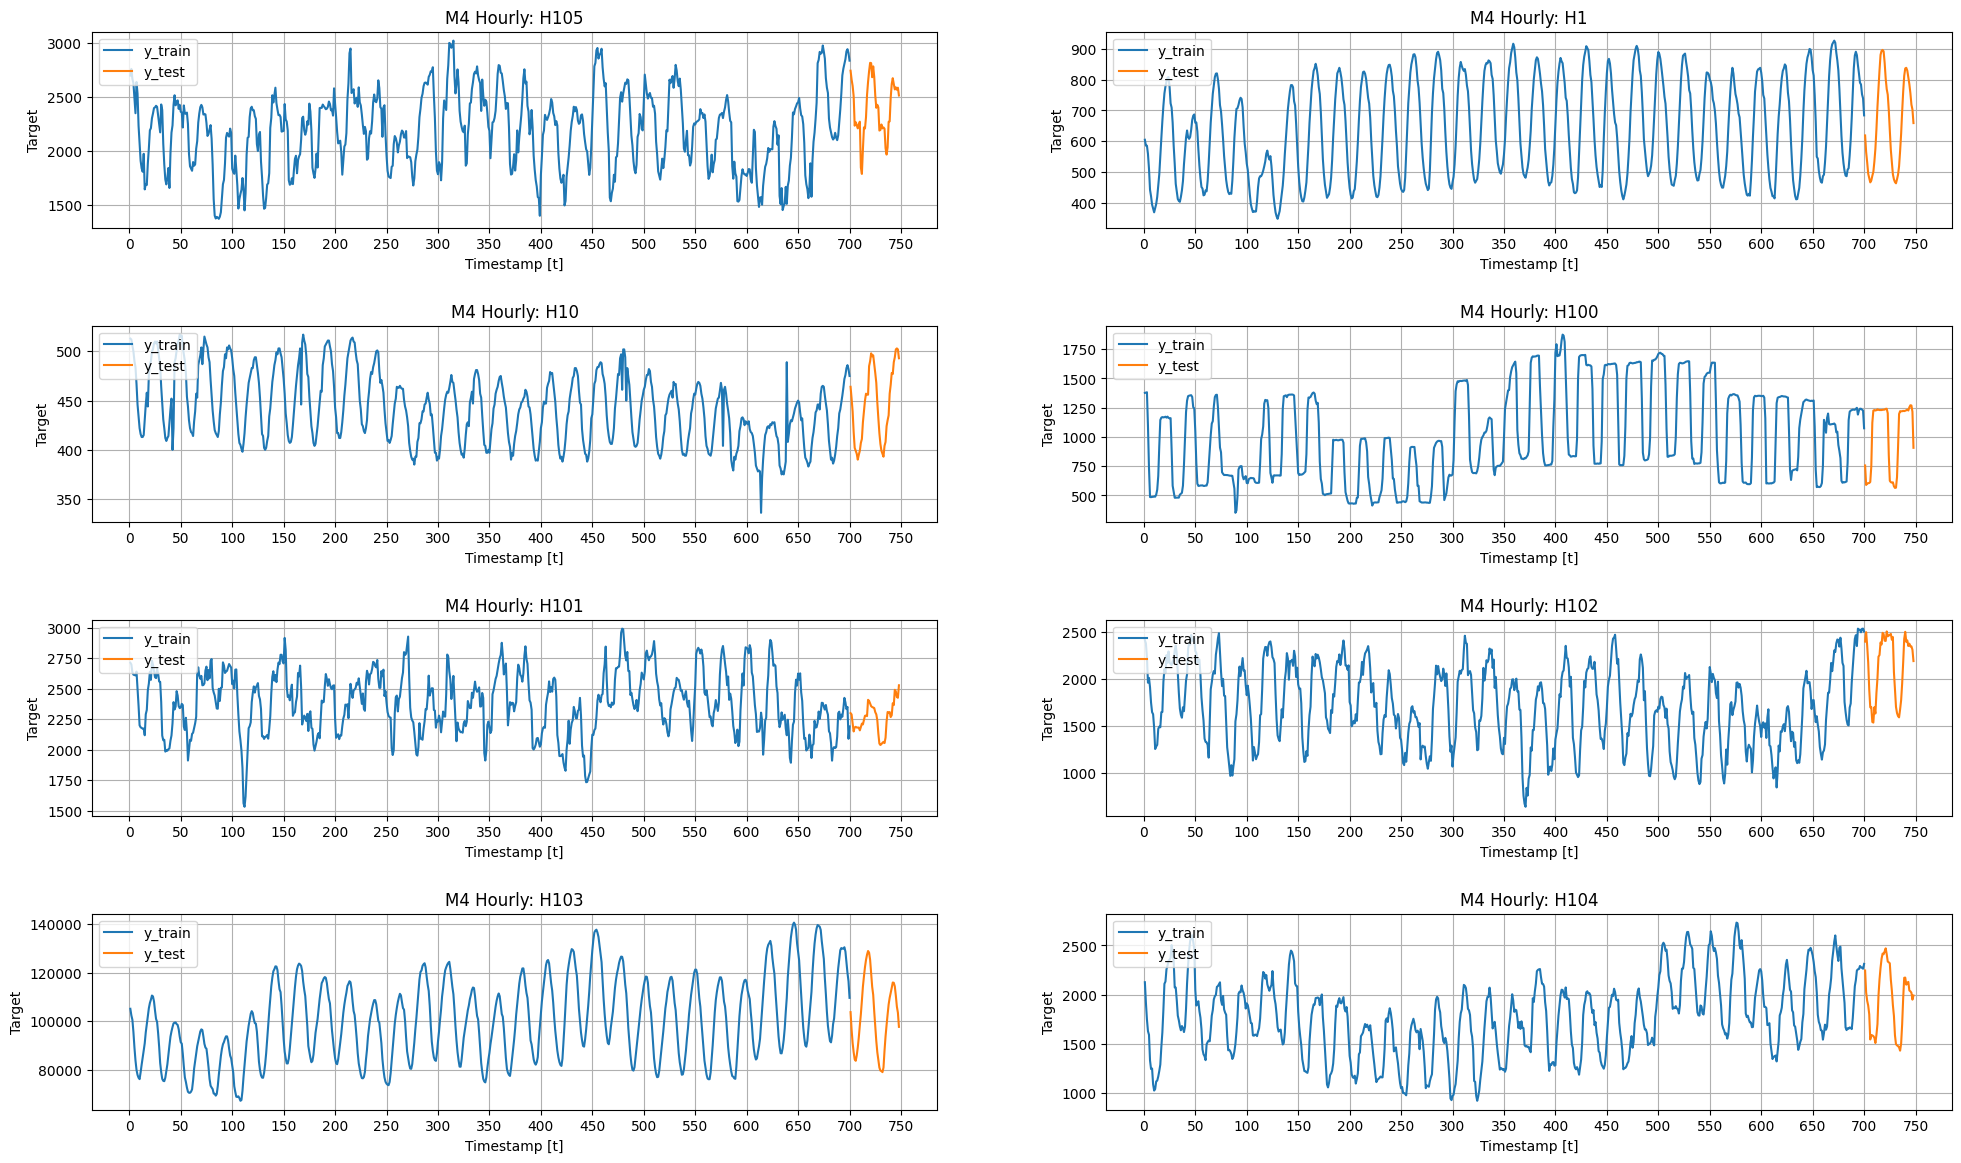

In [ ]:
# Plotting the selected time series
plot_grid(Y_train_df, Y_test_df)

### Model Training

We have already seen how to use `neuralforecast` in Chapter 16. Here, lets see how we can use the same code and make it work for PDF prediction. We are going to use a simple LSTM, but the same strategy and code can be used for all the models in `neuralforecast`.

- The `horizon` parameter controls the number of steps ahead of the predictions, in this example 48 hours ahead (2 days).
- The `DistributionLoss` with `levels=[80,90]` specializes the network's output into the 80% and 90% prediction intervals.
- `input_size` controls the size of the context window
- `encoder_hidden_size` and `decoder_hidden_size` are parameters of the LSTM. We have kept it small so that the run's are faster. These parameters should be ideally tuned and we can use `AutoLSTM` or any of the `Auto<Model>` in `neuralforecast`.

In [1]:
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM
from neuralforecast.losses.pytorch import DistributionLoss

c:\Users\manuj\miniconda3\envs\modern_ts_2E_try2\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
horizon = 48
levels = [80, 90]
lstm_config = dict(
    input_size=3 * horizon, encoder_hidden_size=8, decoder_hidden_size=8
)
models = [
    LSTM(
        h=horizon,
        loss=DistributionLoss(distribution="StudentT", level=levels),
        alias="LSTM_StudentT",
        **lstm_config
    ),
    LSTM(
        h=horizon,
        loss=DistributionLoss(distribution="Normal", level=levels),
        alias="LSTM_Normal",
        **lstm_config
    ),
]
# Setting freq=1 because the ds column is not date, but instead a sequentially increasing number
nf = NeuralForecast(models=models, freq=1)

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


All the models of the library are global, meaning that all time series in `Y_train_df` is used during a shared optimization to train a single model with shared parameters. This is the most common practice in the forecasting literature for deep learning models, and it is known as "cross-learning".

In [ ]:
%%capture
nf.fit(df=Y_train_df)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | loss            | DistributionLoss | 5      | train
1 | padder          | ConstantPad1d    | 0      | train
2 | scaler          | TemporalNorm     | 0      | train
3 | hist_encoder    | LSTM             | 928    | train
4 | context_adapter | Linear           | 4.3 K  | train
5 | mlp_decoder     | MLP              | 115    | train
-------------------------------------------------------------
5.4 K     Trainable params
5         Non-trainable params
5.4 K     Total params
0.021     Total estimated model params size (MB)
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: 

In [ ]:
# Predicting for the next horizon (since we arent using any external regressors, we can just call predict)
# The output should have the point rediction (median) as well as the two prediction intervals according to the levels we have defined
Y_hat_df = nf.predict()
Y_hat_df = Y_hat_df.reset_index()
Y_hat_df.head()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

,unique_id,ds,LSTM_StudentT,LSTM_StudentT-median,LSTM_StudentT-lo-90,LSTM_StudentT-lo-80,LSTM_StudentT-hi-80,LSTM_StudentT-hi-90,LSTM_Normal,LSTM_Normal-median,LSTM_Normal-lo-90,LSTM_Normal-lo-80,LSTM_Normal-hi-80,LSTM_Normal-hi-90
0,H1,701,587.046875,587.485474,478.008881,501.391083,673.079590,698.311523,613.798035,614.233154,532.311096,550.025635,677.824158,694.695862
1,H1,702,558.367432,557.161743,448.269928,479.402893,647.562744,674.318176,548.036438,547.853638,432.249603,461.833710,638.639343,659.279419
2,H1,703,502.397583,503.129944,366.686768,398.185974,603.832764,636.315063,523.126953,523.233948,397.568909,424.950775,622.253540,649.742188
3,H1,704,455.640259,455.857269,314.235748,343.414093,559.233948,587.852783,481.732788,481.041443,347.311981,373.908600,585.119019,613.835510
4,H1,705,439.033112,438.761047,299.523743,336.898224,544.027893,576.329163,451.709534,450.792664,315.543884,347.631683,563.003540,594.553711


In [ ]:
# Merging the predictions back to the test_df
Y_test_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])

### Plotting Predictions

Let's plot the forecast and see how we did.

The output that represents the 90% prediction interval of the network; its lower limit gives the 5th percentile (or 0.05 quantile) while its upper limit gives the 95th percentile (or 0.95 quantile). For well-trained models we expect that the target values lie within the interval 90% of the time.

#### LSTM_StudentT

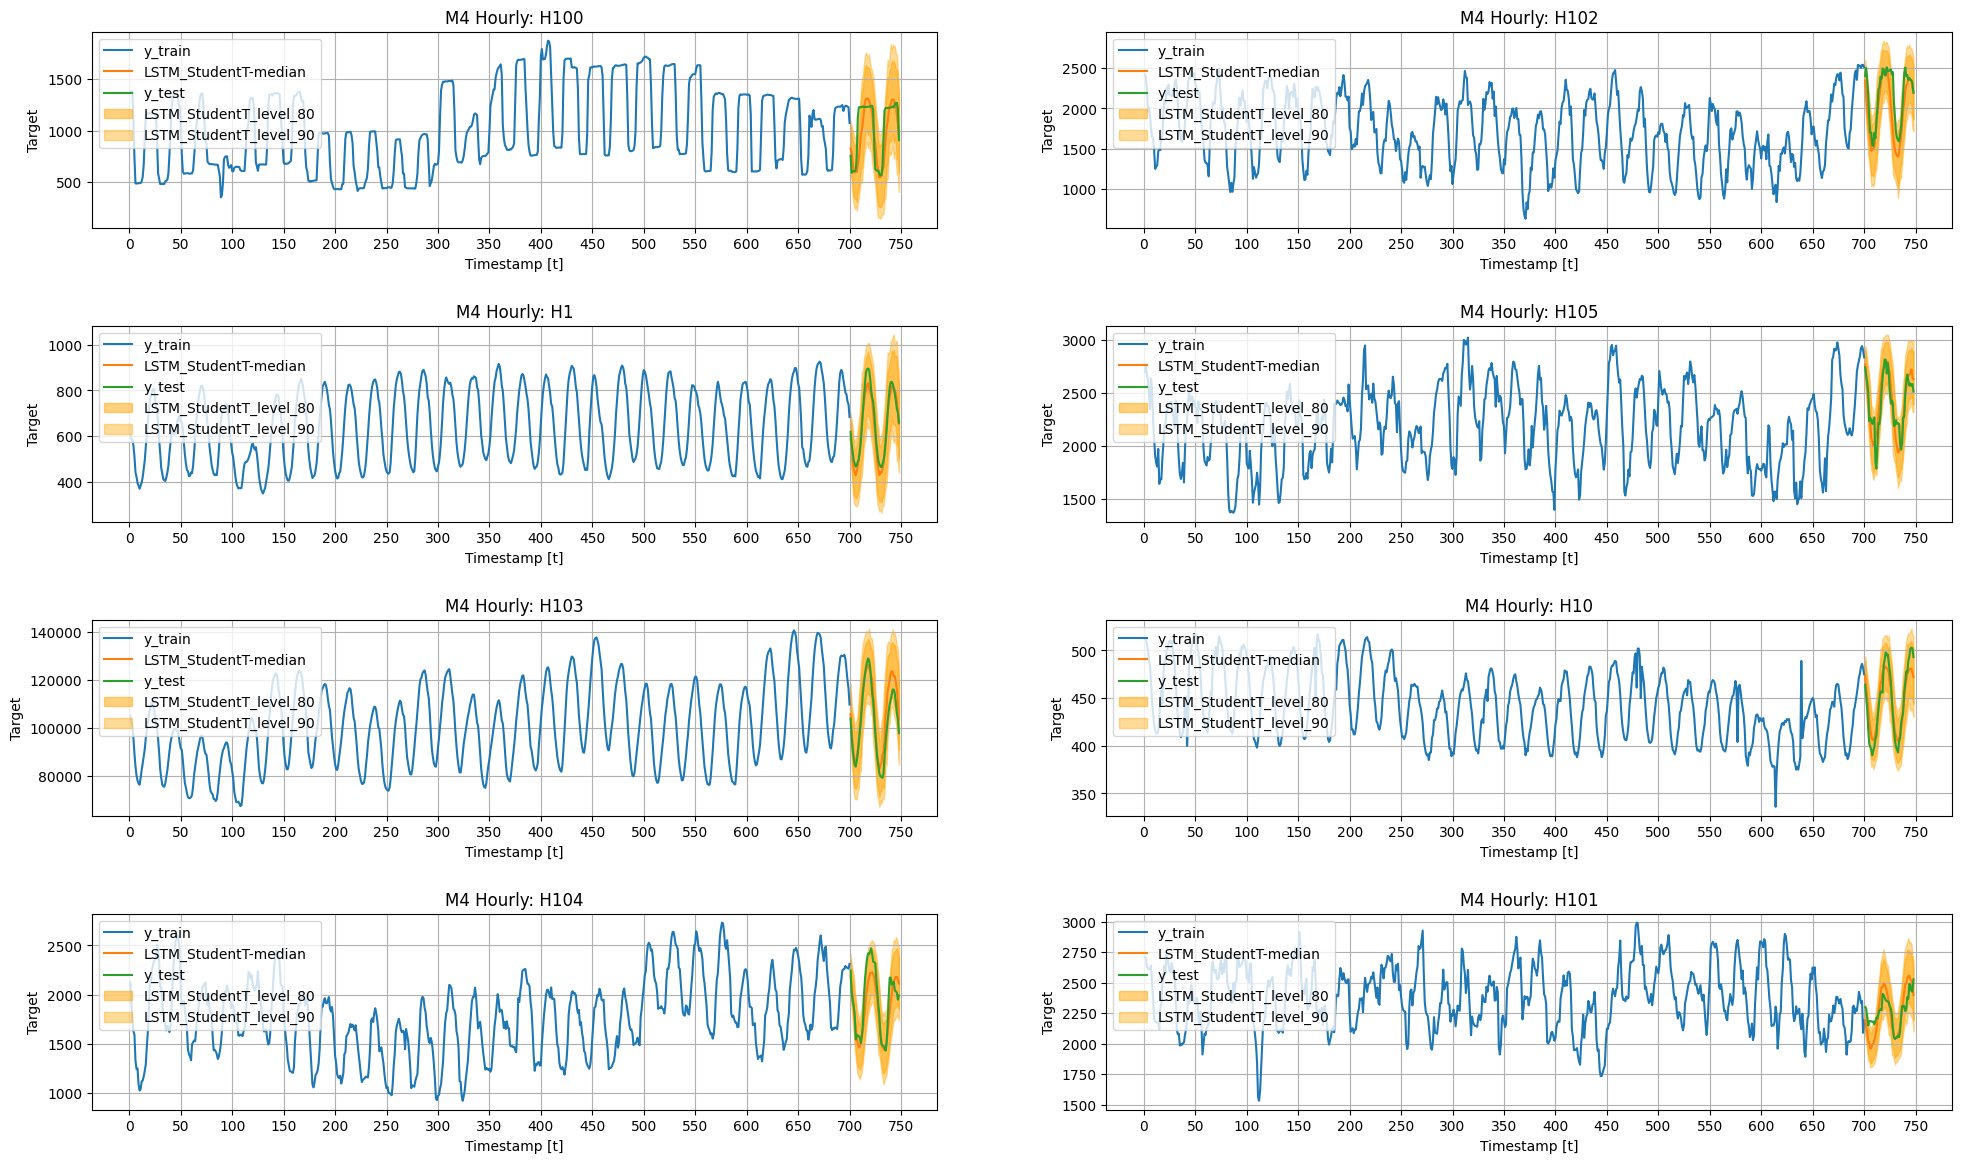

In [ ]:
plot_grid(Y_train_df, Y_test_df, level=levels, model='LSTM_StudentT')

#### LSTM_Normal

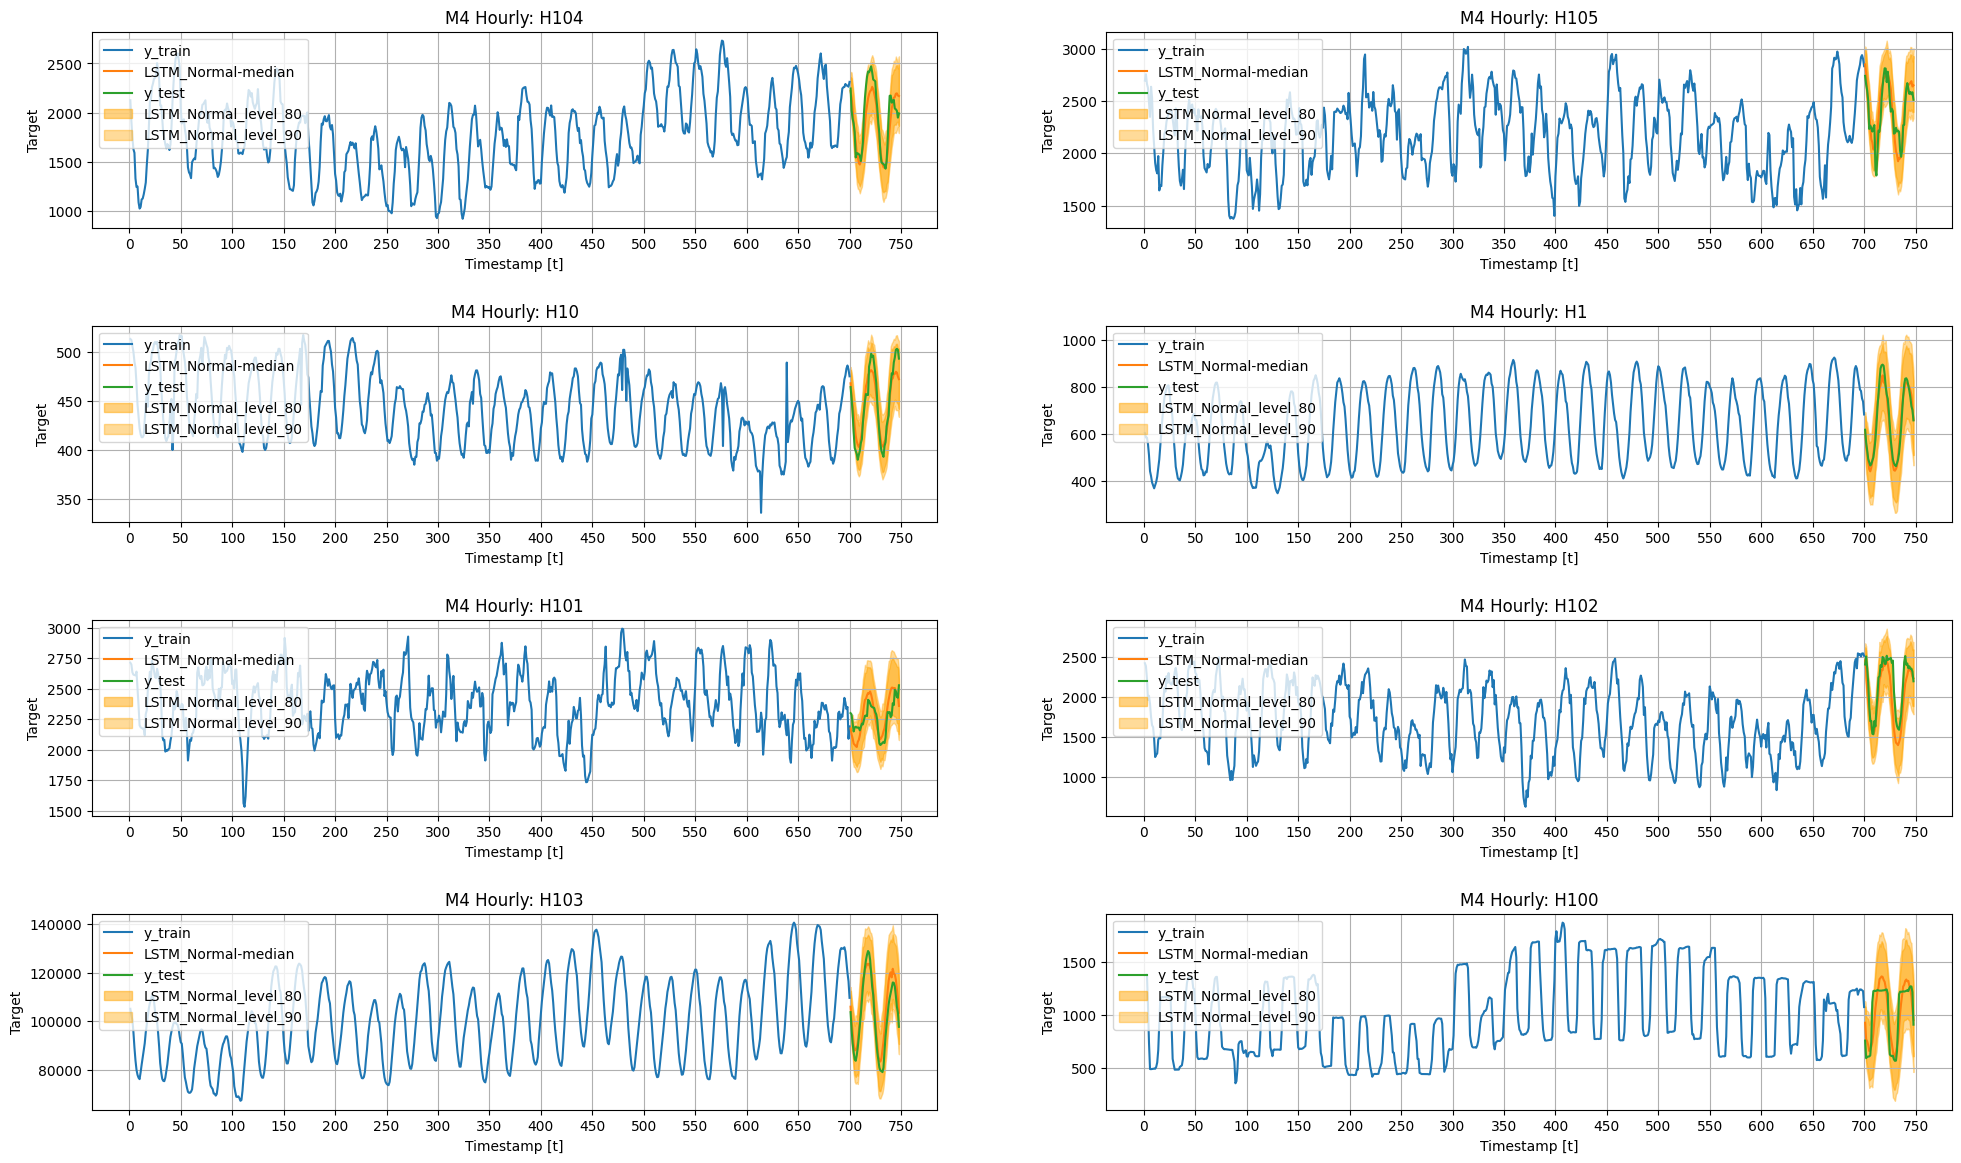

In [ ]:
plot_grid(Y_train_df, Y_test_df, level=levels, model='LSTM_Normal')